In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics 
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
hr = pd.read_csv("/Users/dominicventura/Machine Learning/Neural Network Project/hremployee.csv")

In [3]:
# Potentially drop variables in this line
hr = hr.drop(['Over18', 
              'EmployeeCount',
              'EmployeeNumber',
              'StandardHours'
             ], axis = 1)

In [4]:
# Creating dummy variables
from sklearn.preprocessing import LabelEncoder

for column in hr.columns:
    if hr[column].dtype == np.number:
        continue
    hr[column] = LabelEncoder().fit_transform(hr[column])


In [5]:
hr['Age_new'] = hr['Age']
hr = hr.drop('Age', axis = 1)

In [6]:
# Split and train data
hr_predictors = hr.iloc[:, 1:hr.shape[1]].values
hr_response = hr.iloc[:,0].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(hr_predictors, hr_response, test_size = 0.25, random_state=0)

In [8]:
########## Decision Tree

# Create decision tree classifier
clf = DecisionTreeClassifier(criterion = "entropy", max_depth = 2)

# Train Decision Tree Classifier
clf = clf.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = clf.predict(X_test)

In [9]:
# Checking model accuracy, seeing how well our model predicted correctly
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))

Accuracy: 0.8505434782608695
Precision: 0.5454545454545454
Recall: 0.3103448275862069


In [10]:
########## Beginning of Random Forest (no tuning)

# Create model and train for RF
model = RandomForestClassifier(n_estimators = 10, criterion = "entropy", max_depth = 5, random_state = 0)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [11]:
# Accuracy on train data
model.score(X_train, y_train)

0.868421052631579

In [12]:
# Predict results from test data
predictions = model.predict(X_test)

In [13]:
# Test accuracy
accuracy_score(y_test, predictions)

0.8505434782608695

The random forest module has a nice feature that allows us to find which variables are most important. Being able to find which predictors contribute most to attrition is pretty helpful.

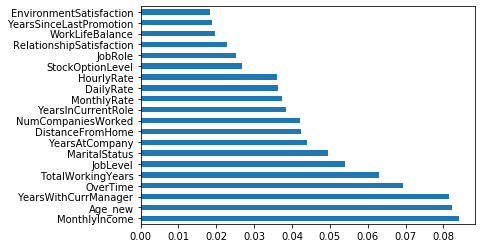

In [26]:
new_response = hr.drop('Attrition', axis = 1)
importances = pd.Series(model.feature_importances_, index = new_response.columns)
importances = importances.nlargest(20)
importances.plot(kind='barh')

In [15]:
from sklearn.metrics import confusion_matrix
conmat = confusion_matrix(y_test, predictions)
trueNeg = conmat[0][0]
truePos = conmat[1][1]
falseNeg = conmat[1][0]
falsePos = conmat[0][1]

print('Model Testing Accuracy: {}' .format( (trueNeg + truePos) / (trueNeg + truePos + falseNeg + falsePos) ))
print("Precision:", metrics.precision_score(y_test, predictions))
print("Recall:", metrics.recall_score(y_test, predictions))

Model Testing Accuracy: 0.8505434782608695
Precision: 0.7142857142857143
Recall: 0.08620689655172414


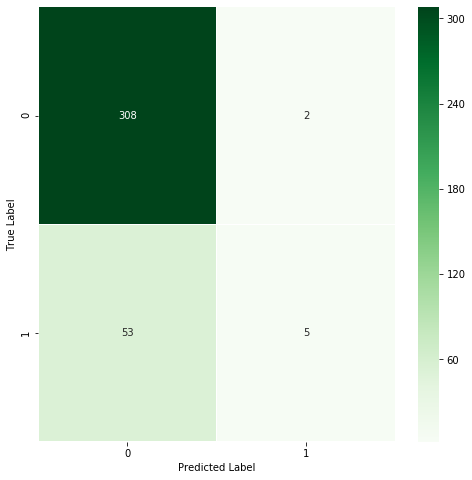

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.subplots(figsize=(8, 8))
sns.heatmap(conmat, annot=True, linewidths=0.01, cmap = 'Greens', fmt ='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Trying Oversampling:

In [14]:
sm = SMOTE(random_state=0, sampling_strategy = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [22]:
model_sm = RandomForestClassifier(n_estimators = 10, criterion = "entropy", max_depth = 5, random_state = 0)
model_sm.fit(X_train_res, y_train_res)

predictions_sm = model_sm.predict(X_test)
print("Oversampling:")
print("Accuracy:", metrics.accuracy_score(y_test, predictions_sm))
print("Precision:", metrics.precision_score(y_test, predictions_sm))
print("Recall:", metrics.recall_score(y_test, predictions_sm))

Oversampling:
Accuracy: 0.7744565217391305
Precision: 0.31343283582089554
Recall: 0.3620689655172414


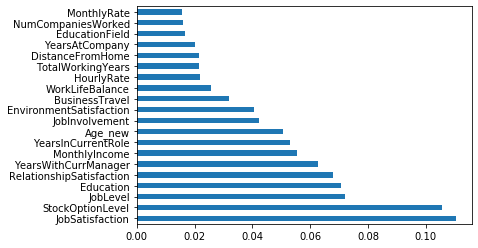

In [25]:
new_response = hr.drop('Attrition', axis = 1)
importances = pd.Series(model_sm.feature_importances_, index = new_response.columns)
importances = importances.nlargest(20)
importances.plot(kind='barh')

In [ ]:
### end of oversampling

In [17]:
############ RF Randomized search parameter tuning

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier

In [19]:
rf = RandomForestClassifier(random_state = 42)

In [20]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [21]:
# Base Model
rf = RandomForestClassifier()

In [22]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 15, cv = 10, verbose = 2,
                              random_state = 0, n_jobs = -1)

In [23]:
# Fit the model
rf_random.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.3s
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/dominicventura/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-ac838c6e82c0>", line 2, in <module>
    rf_random.fit(X_train, y_train)
  File "/Users/dominicventura/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 710, in fit
    self._run_search(evaluate_candidates)
  File "/Users/dominicventura/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 1484, in _run_search
    random_state=self.random_state))
  File "/Users/dominicventura/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py", line 689, in evaluate_candidates
    cv.split(X, y, groups)))
  File "/Users/dominicventura/anaconda3/lib/python3.7/site-packages/joblib/parallel.py", line 934, in __call__
    self.retrieve()
  File "/Users/dominicventura/anaconda3/lib/python3.7/sit

KeyboardInterrupt: 

In [ ]:
opt = rf_random.best_estimator_

In [ ]:
opt.score(X_train, y_train)

In [ ]:
preds = opt.predict(X_test)

In [ ]:
accuracy_score(y_test,preds)

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, preds))
print("Precision:", metrics.precision_score(y_test, preds))
print("Recall:", metrics.recall_score(y_test, preds))

In [ ]:
conmat2 = confusion_matrix(y_test, preds)
trueNeg = conmat[0][0]
truePos = conmat[1][1]
falseNeg = conmat[1][0]
falsePos = conmat[0][1]

plt.subplots(figsize=(8, 8))
sns.heatmap(conmat2, annot=True, linewidths=0.01, cmap = 'Greens', fmt ='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
############ RF Grid Seatch parameter tuning
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
best_grid.score(X_train, y_train)

In [ ]:
preds2 = best_grid.predict(X_test)

In [ ]:
accuracy_score(y_test, preds2)

In [ ]:
print("Accuracy:", metrics.accuracy_score(y_test, preds2))
print("Precision:", metrics.precision_score(y_test, preds2))
print("Recall:", metrics.recall_score(y_test, preds2))

In [ ]:
conmat3 = confusion_matrix(y_test, preds2)
trueNeg = conmat[0][0]
truePos = conmat[1][1]
falseNeg = conmat[1][0]
falsePos = conmat[0][1]

plt.subplots(figsize=(8, 8))
sns.heatmap(conmat3, annot=True, linewidths=0.01, cmap = 'Greens', fmt ='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()